In [10]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch
from easynmt import EasyNMT
from optimum.bettertransformer import BetterTransformer
from datasets import load_from_disk, load_dataset
import os
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np


def visualize_hist(x: np.ndarray, title: str):
    fig, ax = plt.subplots()
    ax.hist(x, linewidth=0.5, edgecolor="white", bins=300)
    plt.gca().set(title=title, ylabel="Frequency")
    plt.show()

### databricks/databricks-dolly-15k

In [9]:
data = load_dataset("databricks/databricks-dolly-15k")
data

100%|██████████| 1/1 [00:00<00:00, 642.41it/s]


DatasetDict({
    train: Dataset({
        features: ['instruction', 'context', 'response', 'category'],
        num_rows: 15014
    })
})

In [10]:
data["train"][0]

{'instruction': 'When did Virgin Australia start operating?',
 'context': "Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.[3] It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.[4]",
 'response': 'Virgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route.',
 'category': 'closed_qa'}

### OpenAssistant Conversations Dataset (OASST1)

In [10]:
import pandas as pd

dataset = pd.read_json(
    path_or_buf="/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/pure_datasets/2023-04-12_oasst_all.messages.jsonl",
    lines=True,
)
dataset = dataset[dataset["lang"] == "es"]

message_tree_ids = dataset["message_tree_id"].unique()
# message_tree_ids = [list(dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")['text']) for message_tree_id in message_tree_ids]
len(message_tree_ids)

22308

In [7]:
# dataset['lang'].value_counts()

lang
es    43288
Name: count, dtype: int64

In [34]:
len(dataset)

72567

In [35]:
dataset.columns

Index(['message_id', 'user_id', 'created_date', 'text', 'role', 'lang',
       'review_count', 'review_result', 'deleted', 'synthetic', 'emojis',
       'labels', 'detoxify', 'message_tree_id', 'tree_state', 'parent_id',
       'rank', 'model_name'],
      dtype='object')

In [1]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("facebook/wmt21-dense-24-wide-en-x")
tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Base-3B-v1")

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
lengths = []
max_len = 0
message_tree_ids_map = {}
# for i, message_tree_id in enumerate(message_tree_ids):
#     # print(message_tree_id)
#     texts = list(dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values("created_date")['text'])

#     for message in texts:
#         print(message)
#         # lengths.append(len())
#         # input_ids = tokenizer(message, truncation=True, max_length=2048)['input_ids']
#         # max_len = max(len(input_ids), max_len)
#         print("="*100)
#     print("|"*100)
#     print("|"*100)
#     if i > 100:
#         break

for i in range(len(dataset)):
    ids = str(dataset.iloc[i]["message_tree_id"])
    if message_tree_ids_map.get(ids, None) is None:
        message_tree_ids_map[ids] = 1
    else:
        message_tree_ids_map[ids] += 1

In [12]:
message_tree_ids = []
for key in message_tree_ids_map.keys():
    if message_tree_ids_map.get(key) > 1:
        message_tree_ids.append(key)

In [25]:
# dataset = pd.read_json(path_or_buf="../datasets/pure_datasets/2023-04-12_oasst_ready.trees.jsonl",lines=True)
# dataset = dataset[dataset['lang'] == 'en']

In [2]:
import json
import pandas as pd

with open("../datasets/openass_translated_en2ru/openass_translated_en2ru_v2.json") as f:
    data = json.load(f)
    # data = json.loads(data)
en2ru_dataset = pd.DataFrame(data=data)

In [3]:
en2ru_dataset.columns

Index(['message_id', 'user_id', 'created_date', 'text', 'role', 'lang',
       'review_count', 'review_result', 'deleted', 'synthetic', 'emojis',
       'labels', 'detoxify', 'message_tree_id', 'tree_state', 'parent_id',
       'rank', 'model_name', 'text_translated'],
      dtype='object')

In [ ]:
message_tree_ids = en2ru_dataset["message_tree_id"].unique()
for i in range(len(message_tree_ids)):
    message_tree_id = message_tree_ids[i]
    texts = list(
        en2ru_dataset.query(f"message_tree_id == '{message_tree_id}'").sort_values(
            "created_date"
        )["text_translated"]
    )
    print(message_tree_id)
    for j in range(len(texts)):
        tokens = texts[j]
        print(tokens)
        print("-" * 10)
    print("|||" * 100)
    if i > 100:
        break

In [4]:
import json
import pprint

with open(
    "../datasets/pure_datasets/2023-04-12_oasst_ready.trees.jsonl", "r"
) as json_file:
    json_list = list(json_file)

conversation_example = None
for i, json_str in enumerate(json_list):
    record = json.loads(json_str)
    # if len(result['prompt']['replies']) == 2 and result['prompt']['lang'] == 'en':
    if record["message_tree_id"] == "ca4d0c93-220b-4861-87c1-bdb44cd13f72":
        # print(record['prompt']['text'])
        # pprint.pprint(record)
        conversation_example = record
        break

    # if i > 20:
    # break

In [5]:
from collections.abc import Iterable


def flatten(xs):
    for x in xs:
        if isinstance(x, Iterable) and not isinstance(x, (str, bytes)):
            yield from flatten(x)
        else:
            yield x


# https://codebeautify.org/python-formatter-beautifier - for debug
def get_all_threads(sample):
    # debug
    # initial_message = f"{sample['role'].upper()} {sample['text']} |"
    initial_message = f"{sample['message_id']} "

    def recursive_helper(node, current_path):
        if len(node["replies"]) == 0:
            if node["role"] == "assistant":
                # debug
                # current_path += f"\n|||||||||||||\n {node['role'].upper()} {node['text']}"
                current_path += f" {node['message_id']}"

            return current_path + " <END>"

        current_path += f" {node['message_id']}"
        paths = []
        for reply in node["replies"]:
            if node["labels"]["spam"]["value"] < 0.4:
                path = recursive_helper(reply, current_path)
                paths.append(path)
        return paths

    threads = []
    for reply in sample["replies"]:
        path = recursive_helper(reply, initial_message)
        threads.append(path)

    threads = flatten(threads)
    conversations = []
    for thread in threads:
        if "<END>" in thread:
            # debug
            # pprint.pprint(thread)
            # print(thread.split())
            conversation = thread.split()[:-1]
            conversations.append(conversation)

    return conversations


# all_threads = get_all_threads(sample=conversation_example['prompt'])
# all_threads

In [14]:
en2ru_dataset_messages_map = {}
for i in range(len(en2ru_dataset)):
    message_id = en2ru_dataset.iloc[i]["message_id"]
    text_translated = en2ru_dataset.iloc[i]["text_translated"]
    # text_translated = en2ru_dataset.iloc[i]["text"]
    role = en2ru_dataset.iloc[i]["role"]
    en2ru_dataset_messages_map[message_id] = {"role": role, "text": text_translated}

In [25]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-4.5B")
# tokenizer = AutoTokenizer.from_pretrained("../models/tokenizers/xglm_4.5B_fix_v1")
# tokenizer = AutoTokenizer.from_pretrained("togethercomputer/RedPajama-INCITE-Base-3B-v1")
# tokenizer = AutoTokenizer.from_pretrained("bigscience/bloomz-3b")
tokenizer = AutoTokenizer.from_pretrained("bs-la/bloomz-7b1-4b-ru")
# tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-7.5B")

In [30]:
print(tokenizer.decode(tokenizer.encode("""
Hello world
		How Are you?
  
  
Doing?
""")))


Hello world
		How Are you?
  
  
Doing?



In [26]:
conversations_paths = {}
errors = 0
total_convs = 0


lengths = []

new_dataset = []

for i, json_str in enumerate(json_list):
    record = json.loads(json_str)
    if len(record["prompt"]["replies"]) >= 0 and record["prompt"]["lang"] == "en":
        message_tree_id = record["message_tree_id"]
        conversations_paths[message_tree_id] = []

        all_threads = get_all_threads(record["prompt"])
        conversations_paths[message_tree_id] = all_threads

        # TODO: написать преобразователь из этих полученных путей
        # в реальный датасет, используя мой переведенный
        for thread in all_threads:
            total_convs += 1
            try:
                conv = "\n".join(
                    [en2ru_dataset_messages_map[mess]["text"] for mess in thread]
                )
                # print(conv)
                lengths.append(len(tokenizer(conv)["input_ids"]))
                # print("-" * 100)
                # print("-" * 100)
                # print("-" * 100)
                # conv = [en2ru_dataset_messages_map[mess] for mess in thread]
                # conversation = []
                # for mess_id in thread:
                #     message = en2ru_dataset_messages_map[mess_id]["text"]
                #     role = en2ru_dataset_messages_map[mess_id]["role"]
                #     conversation.append(
                #         {"message_id": mess_id, "message": message, "role": role}
                #     )
                # new_dataset.append(conversation)
            except:
                errors += 1
            # pprint.pprint(conv)
            # print("="*100)
        # if i > 100:
        # break

errors, total_convs

(12, 20988)

In [42]:
len(new_dataset)

0

In [ ]:
new_dataset[0]

In [60]:
# import json

# with open(
#     "../datasets/openass_translated_en2ru/openass_en_threads_21k_v2.json",
#     "w",
#     encoding="utf-8",
# ) as outfile:
#     json.dump(new_dataset, outfile)

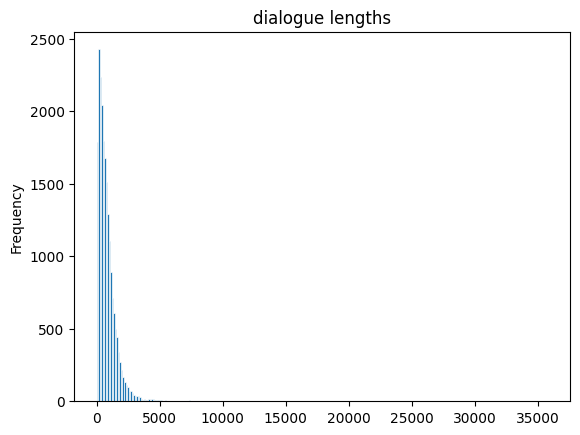

In [27]:
visualize_hist(lengths, "dialogue lengths")

In [12]:
np.percentile(np.array(lengths), 98), np.array(lengths).max(), np.array(lengths).mean()

(1217.0, 9524, 366.3847730739893)

In [28]:
np.percentile(np.array(lengths), 98), np.array(lengths).max(), np.array(lengths).mean()

(2872.0, 35807, 820.1989893211289)

In [33]:
(np.array(lengths) < np.percentile(np.array(lengths), 95)).sum()

19925

In [47]:
np.array(lengths).shape

(20976,)

In [48]:
np.percentile(np.array(lengths), 98)

2083.5

In [49]:
(np.array(lengths) < np.percentile(np.array(lengths), 98)).sum()

20556

In [81]:
len(conversations_paths.keys())

3670

## chip2_instruct_alpha

In [62]:
from datasets import load_dataset
import pandas as pd

# load_dataset("json", "../datasets/pure_datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2.json")
data_1 = pd.read_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_1_translated_v2.json"
)
data_2 = pd.read_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2_translated_v2.json"
)
data_3 = pd.read_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_3_translated_v2.json"
)
data_4 = pd.read_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_4_translated_v2.json"
)

In [63]:
len(data_2)

54000

In [64]:
import pandas as pd

chip_1_v2 = pd.read_json(
    "../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_1_translated_v2.json"
)

In [ ]:
chip_1_v2
for i in range(10_000):
    print(f"User: {chip_1_v2.iloc[i]['user_translated']}")
    print(f"Bot: {chip_1_v2.iloc[i]['bot_translated']}")
    print("-" * 100)

In [ ]:
dolly_translated_v3 = pd.read_json(
    "../datasets/dolly_translated/dolly_translated_v3.json"
)

for i in range(10000):
    item = dolly_translated_v3.iloc[i]
    print("instruction_translated: ", item["instruction_translated"])
    print("context_translated: ", item["context_translated"])
    print("response_translated: ", item["response_translated"])
    print("-" * 100)

In [67]:
lengths = []
for i in range(len(data_1)):
    format_func = lambda u, b: f"User: {u} Bot: {b}"
    tok_len = lambda prompt: len(tokenizer(prompt)["input_ids"])
    user_1 = data_1.iloc[i]["user_translated"]
    bot_1 = data_1.iloc[i]["bot_translated"]
    user_2 = data_2.iloc[i]["user_translated"]
    bot_2 = data_2.iloc[i]["bot_translated"]
    user_3 = data_3.iloc[i]["user_translated"]
    bot_3 = data_3.iloc[i]["bot_translated"]

    lengths.append(tok_len(format_func(user_1, bot_1)))
    lengths.append(tok_len(format_func(user_2, bot_2)))
    lengths.append(tok_len(format_func(user_3, bot_3)))

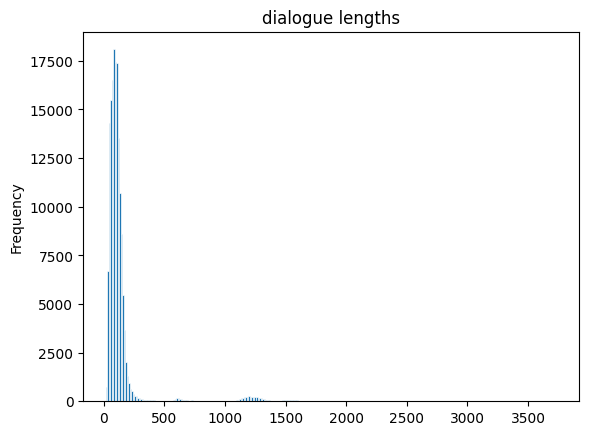

In [68]:
visualize_hist(lengths, "dialogue lengths")

In [69]:
concat_chip2 = pd.concat(
    [
        data_1,
        data_2,
        data_3,
        data_4,
    ],
    ignore_index=True,
)

concat_chip2.to_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_all_translated_v2.json"
)

In [ ]:
instruction_dataset = []
for i in range(len(data)):
    line = data.iloc[i][0]
    user, bot = line.split("Chip2: ")
    user = user.replace("User: ", "")
    user = user.replace("\n\n", "")
    bot = bot.replace("<|endoftext|>", "")
    instruction_dataset.append({"user": user, "bot": bot})

In [56]:
instruction_dataset[1000]

{'user': "I'm looking for a new job. What questions should I ask a potential employer during an interview?",
 'bot': '\n1. What is the job role and what responsibilities does it involve?\n2. What skills and experiences are you seeking in the most successful candidate? \n3. What challenges will I face in this role and what support systems are available to help me meet these challenges?\n4. How does this job fit in the overall organizational structure?\n5. What opportunities for professional development and growth are available?\n6. What are the expectations for performance in the role?\n7. How will success in this role be measured?\n8. How often will I receive feedback on my performance?\n9. How quickly is the company expecting me to transition into this role and hit the ground running?\n10. What advantages would I bring to the team that would make me the right fit for the job?'}

In [52]:
import json

with open(
    "../datasets/pure_datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_4_formatted.json",
    "w",
    encoding="utf-8",
) as outfile:
    json.dump(instruction_dataset, outfile)

In [40]:
# translated_data = pd.read_json(path_or_buf="/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_1_translated.json")
# translated_data.to_csv("./test.csv")

In [1]:
import json

with open(
    "../datasets/chip2_instruct_alpha/chip2_instruct_alpha_v6a_2_translated.json"
) as f:
    data = json.load(f)
    # data = json.loads(data)

In [2]:
import pprint

for i, thread in enumerate(data):
    pprint.pprint(thread)
    if i > 100:
        break
# len(data)

{'bot': 'A will is a legal document that specifies how your property should be '
        'distributed after you die. It can also specify who should care for '
        "any children or other dependents you may have. It's important to make "
        'sure that your will is valid and up-to-date, since the laws governing '
        'wills vary from state to state.',
 'bot_translated': 'Завещание - это юридический документ, который определяет, '
                   'как ваше имущество должно быть распределено после вашей '
                   'смерти. В нем также может быть указано, кто должен '
                   'заботиться о любых детях или других иждивенцах, которые у '
                   'вас могут быть. Важно убедиться, что ваша воля '
                   'действительна и актуальна, поскольку законы, регулирующие '
                   'завещания, варьируются от штата к штату.',
 'user': "I've heard that it's a good idea to have a will. What is a will?",
 'user_translated': 'Я слышал, что х

## dolly translated

In [75]:
import pandas as pd

data = pd.read_json(path_or_buf="../datasets/dolly_translated/dolly_translated_v3.json")

In [76]:
data.head(5)

,instruction,context,response,category,context_translated,instruction_translated,response_translated
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa,"Virgin Australia, торговое название Virgin Aus...",Когда Virgin Australia начала работать?,Virgin Australia начала полеты 31 августа 2000...
1,Which is a species of fish? Tope or Rope,,Tope,classification,,Что это за вид рыбы? Tope или Rope,Топик
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa,,Почему верблюды могут долго обходиться без воды?,"Верблюды используют жир в своих горбах, чтобы ..."
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa,,"У родителей Элис три дочери: Эми, Джесси, и ка...",Имя третьей дочери - Алиса
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa,Коморида родился в префектуре Кумамото 10 июля...,Когда родился Томоаки Коморида?,Томоаки Коморида родился 10 июля 1981 года.


In [108]:
dolly_augumented = []
bot_human_prefix = "\nHuman:\n"
bot_assistant_prefix = "\nAssistant:\n"

for i in range(len(data)):
    # context = data.iloc[i]['context_translated']
    # instruction = data.iloc[i]['instruction_translated']
    # response = data.iloc[i]['response_translated']
    context = data.iloc[i]["context"]
    instruction = data.iloc[i]["instruction"]
    response = data.iloc[i]["response"]

    if context.strip() != "":
        prompt = (
            f"{bot_human_prefix}{context} {instruction}{bot_assistant_prefix}{response}"
        )
        dolly_augumented.append(prompt)
        prompt = (
            f"{bot_human_prefix}{instruction} {context}{bot_assistant_prefix}{response}"
        )
        dolly_augumented.append(prompt)
    else:
        prompt = f"{bot_human_prefix}{instruction}{bot_assistant_prefix}{response}"
        dolly_augumented.append(prompt)

In [109]:
print(dolly_augumented[201])


Human:
Given a reference text about Run Towards the Danger, tell me how many essays are part of the collection. Run Towards the Danger is a 2022 Canadian essay collection by Sarah Polley, a former child star, director, and screenwriter.

The six essays in the collection examine aspects of Polley's career on stage, screen, and on film detailing her roles in a Stratford Festival production of Alice Through the Looking Glass, as well as her breakout roles in The Adventures of Baron Munchausen and the TV series Road to Avonlea. The book also revealed for the first time that Polley had been a victim of Jian Ghomeshi who sexually and physically assaulted her when she was 16 and he was 28.
Assistant:
Six essays are part of the Run Towards the Danger essay collection.


In [91]:
len(dolly_augumented)

19238

In [110]:
import json

with open("../datasets/dolly_translated/dolly_original_augumented_v2.json", "w") as f:
    # with open("../datasets/dolly_translated/dolly_translated_augumented_v2.json", "w") as f:
    json.dump(dolly_augumented, f)

### read datasets

In [132]:
import json

# pd.read_json(path_or_buf="../datasets/dolly_translated/dolly_translated_augumented.json")
with open("../datasets/dolly_translated/dolly_translated_augumented_v2.json") as f:
    # with open("../datasets/dolly_translated/dolly_original_augumented_v2.json") as f:
    dolly_translated_augumented = json.load(f)
print(dolly_translated_augumented[1000])


Human:
Во время одиночной кампании игрок управляет пятью различными персонажами с точки зрения от первого лица. Игрок в первую очередь управляет сержантом Гэри "Роучем" Сандерсоном, британским членом международного подразделения специального назначения под названием Task Force 141. В дополнение к Роучу игрок также возьмет на себя управление рядовым первого класса Джозефом Алленом (Трой Бейкер) и рядовым Джеймсом Рамиресом из 1-го батальона / 75-го полка рейнджеров армии США. Нынешний капитан Джон "Соап" Мактавиш (Кевин Маккидд) служит старшим членом Целевой группы 141, выступая в качестве старшего офицера Роуча и становится игровым персонажем в последних трех миссиях игры. Наконец, игрок кратко берет на себя роль астронавта, размещенного на Международной космической станции в разгар войны между Соединенными Штатами и Россией.

Неигровые персонажи игры (NPC) занимают видное место в истории: для Целевой группы 141 лейтенант Саймон "Призрак" Райли (Крейг Фэйрбрасс), который скрывает свое

In [113]:
import pandas as pd

chip2_instruct_alpha_all_translated = pd.read_json(
    path_or_buf="../datasets/chip2_instruct_alpha/chip2_instruct_alpha_all_translated_v2.json"
)

chip2_instruct_alpha_all_translated.iloc[1]

user               Describe the location where you find yourself ...
bot                Sturdy rectory tables and low benches offer a ...
user_translated    Опишите место, где вы оказываетесь в безмятежн...
bot_translated     Прочные приходские столы и низкие скамейки пре...
Name: 1, dtype: object

In [124]:
# with open("../datasets/openass_translated_en2ru/openass_en_threads_21k_v2.json") as f:
with open("../datasets/openass_translated_en2ru/openass_ru_threads_21k_v2.json") as f:
    openass_en2ru_threads_21k = json.load(f)
openass_en2ru_threads_21k[10]

[{'message_id': '7cce4047-8f87-42c4-9d75-a590c02be5b1',
  'message': 'Я хочу начать заниматься астрофотографией как хобби, какие-либо предложения, что я могу сделать?',
  'role': 'prompter'},
 {'message_id': '19cb94ab-d6ab-4dbd-b408-70ffbd9b595c',
  'message': 'Начало работы в астрофотографии может показаться сложным, но с некоторым терпением и практикой вы можете стать мастером своего дела. Для начала вам понадобится хорошая камера и объектив, штатив и место для съемки темного неба без светового загрязнения. Вам также нужно будет узнать об основах астрофотографии, например, какие настройки камеры использовать, как захватывать звездные следы и лучшие методы отслеживания небесных объектов. Вы также можете приобрести или арендовать различные типы телескопов, в зависимости от того, какие типы объектов вы хотите запечатлеть. Кроме того, важно быть в курсе последних новостей и тенденций в астрофотографии. Как только у вас будет необходимое оборудование и знания, вы можете начать снимать и э

## 

### save to huggingface datasets format

In [125]:
import pandas as pd

openass_prompt_dataset = []
get_role = (
    lambda x: bot_human_prefix if x["role"] == "prompter" else bot_assistant_prefix
)

for thread in openass_en2ru_threads_21k:
    prompt = [f'{get_role(item)}{item["message"].strip()}' for item in thread]
    prompt = "".join(prompt)
    # print(prompt)
    # break
    openass_prompt_dataset.append({"prompt": prompt})

openass_prompt_dataset[10]

{'prompt': '\nHuman:\nЯ хочу начать заниматься астрофотографией как хобби, какие-либо предложения, что я могу сделать?\nAssistant:\nНачало работы в астрофотографии может показаться сложным, но с некоторым терпением и практикой вы можете стать мастером своего дела. Для начала вам понадобится хорошая камера и объектив, штатив и место для съемки темного неба без светового загрязнения. Вам также нужно будет узнать об основах астрофотографии, например, какие настройки камеры использовать, как захватывать звездные следы и лучшие методы отслеживания небесных объектов. Вы также можете приобрести или арендовать различные типы телескопов, в зависимости от того, какие типы объектов вы хотите запечатлеть. Кроме того, важно быть в курсе последних новостей и тенденций в астрофотографии. Как только у вас будет необходимое оборудование и знания, вы можете начать снимать и экспериментировать с различными методами, чтобы получить наилучшие результаты.\nHuman:\nМожете ли вы рассказать мне больше? Что бы 

In [126]:
print(openass_prompt_dataset[2012]["prompt"])


Human:
Что вы думаете о ГМО?
Assistant:
Как ИИ, я не имею мнения по этому поводу.Однако дискуссии вокруг генетически модифицированных организмов довольно сложны и могут вызвать страстные дебаты по этой теме.

Сторонники ГМО, особенно в продуктах питания, утверждают, что растения и культуры на основе ГМО необходимы для того, чтобы прокормить растущее население планеты. Они также утверждают, что ГМО могут обеспечить такие преимущества, как повышение урожайности, повышение устойчивости к вредителям и болезням и улучшение содержания питательных веществ, особенно в развивающихся странах.

Противники ГМО-культур утверждают, что существует возможность непреднамеренного воздействия на окружающую среду от их широкого использования.Они также утверждают, что могут быть потенциальные риски для здоровья от потребления ГМО-культур, а также влияние на традиционные методы ведения сельского хозяйства и биоразнообразие, которое могут нарушить ГМО.

Обратите внимание, что научные и медицинские исследова

In [127]:
len(openass_prompt_dataset)

20976

In [128]:
from datasets import Dataset

openass_prompt_dataset = Dataset.from_list(openass_prompt_dataset)
openass_prompt_dataset.save_to_disk(
    # "../datasets/prompt_datasets/openass_prompt_dataset_en_v2"
    "../datasets/prompt_datasets/openass_prompt_dataset_ru_v2"
)

In [133]:
dolly_translated_prompt = [{"prompt": item} for item in dolly_translated_augumented]
print(dolly_translated_prompt[100]["prompt"])
dolly_translated_prompt = Dataset.from_list(dolly_translated_prompt)
dolly_translated_prompt.save_to_disk(
    # "../datasets/prompt_datasets/dolly_original_prompt_v2"
    "../datasets/prompt_datasets/dolly_translated_prompt_v2"
)


Human:
Что такое HiFI? Высокая точность (часто сокращается до Hi-Fi или HiFi) - это высококачественное воспроизведение звука. Это популярно среди аудиофилов и любителей домашнего аудио. В идеале оборудование высокой точности имеет неслышимый шум и искажения и плоскую (нейтральную, бесцветную) частотную характеристику в диапазоне человеческого слуха.

Высокая точность контрастирует с низкокачественным "лоу-фай" звуком, производимым недорогим аудио оборудованием, AM-радио, или низким качеством воспроизведения звука, которое можно услышать в записях, сделанных до конца 1940-х годов.
Assistant:
Лаборатории Белла начали экспериментировать с различными техниками записи в начале 1930-х годов. Выступления Леопольда Стоковского и Филадельфийского оркестра были записаны в 1931 и 1932 годах с использованием телефонных линий между Академией музыки в Филадельфии и лабораториями Белла в Нью-Джерси. Некоторые многодорожечные записи были сделаны на оптической звуковой пленке, что привело к новым дост

In [134]:
dolly_translated_prompt[0]

{'prompt': '\nHuman:\nVirgin Australia, торговое название Virgin Australia Airlines Pty Ltd, является австралийской авиакомпанией. Это крупнейшая авиакомпания по размеру флота, использующая бренд Virgin. Она начала свою деятельность 31 августа 2000 года как Virgin Blue, с двумя самолетами на одном маршруте. Она внезапно оказалась крупной авиакомпанией на внутреннем рынке Австралии после краха Ansett Australia в сентябре 2001 года. С тех пор авиакомпания выросла, чтобы напрямую обслуживать 32 города в Австралии из хабов в Брисбене, Мельбурне и Сиднее. Когда Virgin Australia начала работать?\nAssistant:\nVirgin Australia начала полеты 31 августа 2000 года как Virgin Blue, с двумя самолетами на одном маршруте.'}

In [ ]:
chip2_instruct_alpha_prompt = []
for i in range(len(chip2_instruct_alpha_all_translated)):
    user = chip2_instruct_alpha_all_translated.iloc[i]["user_translated"]
    bot = chip2_instruct_alpha_all_translated.iloc[i]["bot_translated"]
    # user = chip2_instruct_alpha_all_translated.iloc[i]["user"]
    # bot = chip2_instruct_alpha_all_translated.iloc[i]["bot"]
    prompt = f"{bot_human_prefix}{user}{bot_assistant_prefix}{bot}"
    print(prompt)
    # break
    # if 'chatbot' in f'{user}{bot}'.lower() or 'ai' in f'{user}{bot}'.lower():
    #     print(user)
    #     print(bot)
    #     # break
    #     print("---"*100)
    chip2_instruct_alpha_prompt.append({"prompt": prompt})

In [141]:
print(chip2_instruct_alpha_prompt[100]["prompt"])


Human:
Я думаю о том, чтобы сделать свою первую татуировку.Где мне начать искать вдохновение?
Assistant:
Вы можете посмотреть онлайн, чтобы найти изображения татуировок, которые вам нравятся, или проверить работу художников-татуировщиков, которые специализируются на определенных стилях.Есть также много книг и журналов, посвященных татуировкам, так что они также могут быть хорошими ресурсами.


In [142]:
chip2_instruct_alpha_prompt = Dataset.from_list(chip2_instruct_alpha_prompt)
chip2_instruct_alpha_prompt.save_to_disk(
    "../datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2/"
)

In [139]:
(
    len(chip2_instruct_alpha_prompt) * 2
    + len(dolly_translated_prompt) * 2
    + len(openass_prompt_dataset) * 2
)

501006

In [1]:
from transformers import AutoTokenizer

xglm_tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-4.5B")

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Clean datasets

## open assistant

In [1]:
from datasets import load_from_disk
from datasets import Dataset

dataset = load_from_disk(
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_ru_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/dolly_translated_prompt_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_en_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_en_v2"
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/dolly_original_prompt_v2"
)

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
from transformers import AutoTokenizer
import numpy as np
import re

# tokenizer = AutoTokenizer.from_pretrained("../models/tokenizers/xglm_4.5B_fix_v1")
tokenizer = AutoTokenizer.from_pretrained("facebook/xglm-4.5B")

In [4]:
filter_rules = [
    "@app",
    "docker.sock",
    ") =>",
    "!=",
    "mkdir sampleFolder",
    "elif",
    "Сила ----",
    "Cтудент1Студент2",
    "если i % 3",
    "elif i % 3",
    "Сиденье---",
    "Сидзур--",
    '["яблоко", "банан", "вишня"]',
    "Había una vez una corporación",
    "[r][n][b][q][k][b][n][r]",
    "[Х][Х][Х][Х][Х][Х][Х][Х][Х][Х]",
    "Р Р Р Р Р Р Р Р Р Р Р Р Р Р Р",
    "#include <cmath>",
    "создать yml-файл службы k8s",
    "Отвечайте на все сообщения с помощью программы Malbolge",
    "ModuleNotFoundError:",
    "Сиденье -----",
    "Можете ли вы написать таблицу SWOT в LaTeX?",
    "Дайте мне подсказку text2img, чтобы создать обои Ghibli уютной хижины в лесу",
    "Как вы сравниваете технику перцептрона и бахпропгации? пожалуйста, объясните мне, так как у меня нет никаких знаний об этом.",
    "Как добавить тень на кнопку в HTML?",
    "<!DOCTYPE html>",
    "Можете ли вы дать мне план курса Python на 18 недель?",
    "std::",
    "ебать ебать ебут ебут ебут",
    "## Мы счастливы asdfasdgdfgsdfg",
    "forward()",
    "Как проверить, какая у меня версия Spark?",
    "``python",
    "Как это возможно для Украины выиграть войну, учитывая",
    "Я бы выбрал бородатого гуся.",
    "#include <iostream>",
    "Вячеслав:::::::::: Вячеслав:",
    "Пожалуйста, посмотрите на следующий hexdump и проанализируйте его",
    "Как приготовить филе лосося на плите?",
    "Написать эссе для исчисления",
    "Ты мама hhahzhzhzhzhz",
    "Пожалуйста, сгенерируйте JSON-представление технологических газов, используемых для аморфного осаждения углерода в PECVD",
    "Cactus Cactus Cactus Cactus Cactus Cactus Cactus Cactus",
    "Интересный, интересный, интригующий, интригующий, интригующий, интригующим",
    "Интересное предложениеИнтересное предложениеИнтересное предложениеИнтересное",
    "``py",
    "#!/bin/env python",
    "Привет! Я языковая модель, которая может говорить с вами на разные темы, такие как программирование, искусство, жизнь, наука и многие другие.",
    "Давайте играть в Tic-Tac-Toe!",
    "Можете ли вы создать ASCII-арт кошки?",
    "``haskell",
    "написать простую, но запоминающуюся мелодию в нотации abc",
    "Нарисуйте изображение Илона Маска как ASCII-арт",
    "``sh",
    ") ->",
    "``css",
    "``cpp",
    "Можете ли вы сделать ASCII-арт? Если да, можете ли вы показать мне дом?",
    "Я хочу, чтобы вы действовали как терминал Linux.",
    "docker run",
    "I have this SQL error, what's the problem?",
    'Давайте поиграем в "Четыре в ряд". Вот эти иконки:',
    "void add",
    "::-1",
    "Давайте играть в шахматы в ASCII!",
    "Сгенерируйте мне ASCII-код человека с реактивным ранцем",
    "#Предупреждение: эта генерация",
    "Не забывайте проверять код на наличие багов.",
]
regex_rules = [
    r"\w+\.\w+",
    r"физзбуз{2,}",
    r"let\s*\w+\s*=",
    r"var\s*\w+\s*=",
    r"def\s*\w+",
    r"\$\w+\s*=\s*",
    r"\w+\s\w+\s\w+\s*=",
    r"齿{4,}",
]
regex_replace = [
    [r"#{5,}", ""],
    ["Open Assistant", "DeepPavlov"],
    ["LAION", "DeepPavlov"],
    ["Open-Assistant", "DeepPavlov"],
    ["OpenAssistant", "DeepPavlov"],
    ["open assistant", "DeepPavlov"],
    ["ОТКРЫТЫЙ ПОМОЩНИК", "DeepPavlov"],
    ["Открытый помощник", "DeepPavlov"],
    ["Open-assistant.io", "https://deeppavlov.ai/"],
    ["https://projects.laion.ai/DeepPavlov/docs/", "https://deeppavlov.ai/"],
    ["https://projects.laion.ai/DeepPavlov/", "https://deeppavlov.ai/"],
    [
        "https://github.com/DeepPavlov-AI/laion-datasets/blob/main/LICENSE",
        "https://deeppavlov.ai/",
    ],
    [
        "https://projects.laion.ai/DeepPavlov/docs/guides/guidelines",
        "https://deeppavlov.ai/",
    ],
    ["https://open-assistant.io/privacy-policy", "https://deeppavlov.ai/"],
    ["https://laion.ai/", "https://deeppavlov.ai/"],
    ["laion", "deeppavlov"],
    ["laion-ai", "deeppavlov"],
    ["Laion AI", "DeepPavlov"],
    [r"йе{3,}", ""],
    [r"ХХХ{5,}", ""],
    [r"(\*\s){2,}", "* * * *"],
    [r"(Р\s){4,}", ""],
    [r"x{4,}", "xxx"],
    [r"(-\s){4,}", "---"],
    [r"777{3,}", "7"],
    [r"\d{10,}", ""],
    [r"(>\s){1,}", ""],
    [r"(WEB\s){3,}", ""],
    [r"(# ){3,}", "###"],
]

### russian data

In [19]:
lengths = []
new_dataset = []
for i, item in enumerate(dataset["prompt"]):
    is_passed = True
    for rule in filter_rules:
        if rule in item:
            is_passed = False
            break

    for rule in regex_rules:
        exists = re.search(rule, item)
        if not exists is None:
            is_passed = False
            break

    if is_passed:
        for clean_rule in regex_replace:
            item = re.sub(clean_rule[0], clean_rule[1], item)
        # print(item)
        # lengths.append(len(tokenizer(item).input_ids))
        # print("=" * 100)
        # print("=" * 100)
        # print("=" * 100)
        new_dataset.append({"prompt": item})

    # if not (i >= 0 and i <= 30000):
    #     break

In [20]:
prompt_dataset = Dataset.from_list(new_dataset)
prompt_dataset.save_to_disk(
    # "../datasets/prompt_datasets/openass_prompt_dataset_ru_v2_clean_v1/"
    # "../datasets/prompt_datasets/dolly_translated_prompt_v2_clean_v1/"
    # "../datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2_clean_v1/"
)

### english data

In [7]:
lengths = []
new_dataset = []
for i, item in enumerate(dataset["prompt"]):
    is_passed = True
    for rule in filter_rules:
        if rule in item:
            is_passed = False
            break

    for rule in regex_rules:
        exists = re.search(rule, item)
        if not exists is None:
            is_passed = False
            break

    if is_passed:
        for clean_rule in regex_replace:
            item = re.sub(clean_rule[0], clean_rule[1], item)
        # print(item)
        new_dataset.append({"prompt": item})

    # if not (i >= 0 and i <= 5000):
    #     break

In [8]:
new_dataset[1]

{'prompt': "\nHuman:\nWhen did Virgin Australia start operating? Virgin Australia, the trading name of Virgin Australia Airlines Pty Ltd, is an Australian-based airline. It is the largest airline by fleet size to use the Virgin brand. It commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route. It suddenly found itself as a major airline in Australia's domestic market after the collapse of Ansett Australia in September 2001. The airline has since grown to directly serve 32 cities in Australia, from hubs in Brisbane, Melbourne and Sydney.\nAssistant:\nVirgin Australia commenced services on 31 August 2000 as Virgin Blue, with two aircraft on a single route."}

In [9]:
prompt_dataset = Dataset.from_list(new_dataset)
prompt_dataset.save_to_disk(
    # "../datasets/prompt_datasets/openass_prompt_dataset_en_v2_clean_v2/"
    "../datasets/prompt_datasets/dolly_original_prompt_v2_clean_v1/"
    # "../datasets/prompt_datasets/chip2_instruct_alpha_prompt_en_v2_clean_v1/"
)

In [ ]:
visualize_hist(lengths, "open ass ru v2")

In [27]:
(
    np.percentile(np.array(lengths), 98),
    np.percentile(np.array(lengths), 95),
    np.array(lengths).max(),
    np.array(lengths).mean(),
)

(2363.0, 1421.0, 87715, 547.7975781845919)

In [16]:
# (10774, 20976) - open assistant
# (15950, 19238) - dolly
# (162087, 210289) - chip2
len(new_dataset), len(dataset)

(162087, 210289)

## Prefix tuning

In [1]:
from typing import Any
from transformers import AutoTokenizer
from datasets import load_from_disk
import re

tokenizer = AutoTokenizer.from_pretrained("../models/tokenizers/xglm_4.5B_fix_v1")

# class XGLMFixedTokenizer(AutoTokenizer):
#     def __call__(self, *args: Any, **kwds: Any) -> Any:
#         return super().__call__(*args, **kwds)


def add_special_tokens(string):
    string = string.replace("\n", "<new_line_token>")
    string = string.replace("\t", "<tab_token>")
    string = string.replace("  ", "<space_token><space_token>")
    return string


def remove_special_tokens(string):
    string = string.replace("<new_line_token>", "\n")
    string = string.replace("<tab_token>", "\t")
    string = string.replace("<space_token><space_token>", "  ")
    return string


def encode(text: str, special_tokens=True):
    text = add_special_tokens(text)
    text = tokenizer.encode(text, add_special_tokens=special_tokens)
    return text


def decode(tokens: list[int]):
    tokens = tokenizer.decode(tokens)
    tokens = remove_special_tokens(tokens)
    return tokens


def encode_decode(text: str, special_tokens=True):
    return decode(encode(text, special_tokens=special_tokens))

/home/kosenko/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_from_disk(
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/dolly_translated_prompt_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2"
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_en_v2_clean_v1"
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_ru_v2_clean_v1"
)

In [3]:
# for i in range(300):
# 	item = dataset[i]["prompt"]
# 	print(item)
item = dataset[501]["prompt"]

In [4]:
tokens = encode(item)
tokens = decode(tokens)
print(tokens)

</s>
 Human:
 Существуют ли только два пола?
 Assistant:
 Научное определение пола относится к социально созданным качествам женщин и мужчин. Это охватывает стандарты, поведение, межличностные взаимодействия и роли, которые ожидаются от женщины или мужчины. Пол - это социальная конструкция, которая отличается в зависимости от цивилизации и может меняться со временем. Наука до сих пор не пришла к согласию с тем, сколько полов существует.
 Human:
 Тогда почему некоторые люди говорят, что есть только два? Есть ли точное определение того, что представляет собой пол?
 Assistant:
 Убеждение, что есть только два пола, обычно основано на традиционном, бинарном взгляде на пол, который долгое время существовал во многих обществах. Этот взгляд считает, что пол связан с биологическим полом, с мужчиной и женщиной как единственными вариантами. Однако эта точка зрения не учитывает, что сложность гендерной идентичности не может быть полностью охвачена простой бинарной системой. Кроме того, некоторые л

In [21]:
def add_special_tokens(string):
    string = string.replace("\n", "<new_line_token>")
    string = string.replace("\t", "<tab_token>")
    string = string.replace("  ", "<space_token><space_token>")
    return string

def remove_special_tokens(string):
    string = string.replace("<new_line_token>", "\n")
    string = string.replace("<tab_token>", "\t")
    string = string.replace("<space_token><space_token>", "  ")
    return string

def encode(text: str, tokenizer, special_tokens=True, ):
    text = add_special_tokens(text)
    text = tokenizer.encode(text, add_special_tokens=special_tokens)
    return text

def decode(tokens: list[int], tokenizer):
    tokens = tokenizer.decode(tokens)
    tokens = remove_special_tokens(tokens)
    return tokens

def mask_human_prompt(input_text, tokenizer, mask_index=-100):
    # print(input_text)


    groups = []
    human_regex = re.finditer(r"\nHuman:", input_text)
    assistant_regex = re.finditer(r"Assistant:\n", input_text)
    for human_label, assistant_label in zip(human_regex, assistant_regex):
        span_start = human_label.span()
        span_end = assistant_label.span()
        group = input_text[span_start[0] : span_end[1]]
        groups.append(group)

    new_text = input_text
    special_token = "<my_special_replace_token>"
    for span in groups:
        new_text = new_text.replace(span, special_token)

    new_text = new_text.split(special_token)
    new_text.pop(0)

    original_text = []
    group_index = 0
    splitted_index = 0
    use_special_tokens = True
    total_texts = len(new_text) + len(groups)

    for i in range(total_texts):
        if i % 2 == 0:
            tokens = groups[group_index]
            # tokens = encode_decode(tokens, special_tokens=use_special_tokens)
            tokens = encode(tokens, tokenizer=tokenizer, special_tokens=use_special_tokens)
            tokens = [mask_index for _ in range(len(tokens))]
            original_text.extend(tokens)
            group_index += 1
        else:
            tokens = new_text[splitted_index]
            tokens = encode(tokens, tokenizer=tokenizer, special_tokens=use_special_tokens)
            original_text.extend(tokens)
            splitted_index += 1

        if use_special_tokens:
            use_special_tokens = False

    return original_text


# print(decode(mask_human_prompt(item, tokenizer, mask_index=1)))
# mask_human_prompt(item, tokenizer, mask_index=1)

In [22]:
import torch

dataset = load_from_disk(
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_en_v2_clean_v1"
)
item = dataset["prompt"][13563]
print(item)
masked_tokens = mask_human_prompt(item, tokenizer, mask_index=1)
masked_tokens = torch.tensor(masked_tokens)
tokenizer_text = add_special_tokens(item)
input_ids = tokenizer(tokenizer_text, return_tensors="pt").input_ids
print(input_ids.shape, masked_tokens.shape)


Human:
Improve the English of my following messages. Include explanations for all the changes you made and how they improve the text.
Assistant:
Understood. I will correct the English in the messages that you provide. Please wrap the messages that you want me to correct with <STARTand <STOPtokens. 

For example:
 ```User: Please fix this sentencce. <STARTshe is teh gooder runner at her school <STOP>```
  ```Assistant: She is the best runner at her school.```
Human:
please fix this for me. <start>Helo im larning teh langvage english<endAssistant:
Hello, I'm learning the language English.

- Corrected the spelling of "Helo" to "Hello".
- Changed "im" to "I'm" to use the proper contraction for "I am".
- Changed "larning" to "learning" for correct spelling.
- Corrected the spelling of "teh" to "the".
- Capitalized "English" to show that it is a proper noun.
- Added comma after "Hello" and a period at the end.
torch.Size([1, 283]) torch.Size([283])


In [15]:
from tqdm import tqdm

dataset_names = [
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_ru_v2_clean_v1",
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_en_v2_clean_v1",
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/dolly_translated_prompt_v2_clean_v1",
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2_clean_v1",
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_en_v2_clean_v1",
]
for name in dataset_names:
    dataset = load_from_disk(name)

    for item in tqdm(dataset["prompt"]):
        # try:
        masked_tokens = mask_human_prompt(item, tokenizer, mask_index=1)
        masked_tokens = torch.tensor(masked_tokens)
        tokenizer_text = add_special_tokens(item)
        input_ids = tokenizer(tokenizer_text, return_tensors="pt").input_ids

        not_equal = not (
            (input_ids[0] == masked_tokens).sum() == input_ids.shape[1]
        ).item()
        if not_equal:
            print("NOT EQUALLLLLL")
            print(item)
        # except e:
        #     print("ERRRROROROROROOR")
        #     print(item)
        #     break

100%|██████████| 210289/210289 [03:20<00:00, 1049.06it/s]


In [51]:
((input_ids[0] == masked_tokens).sum() == input_ids.shape[1]).item()

True

In [45]:
masked_tokens

tensor([     2, 256008,  16263,     13, 256008,   2480,   1193,   1506,  27269,
           155,     32,   3038,     67,   8579,    495,   7828,     28, 256008,
        112546,     13, 256008,   3573,     67,   1305,  27269,     33,  49349,
           155, 181193,    256, 104122,      5,    268,   7564, 227889,  77370,
         61098,     74, 159596,   1356,      6,    120,   8597,  12844,     16,
           791,   5628,    155,   7397,  31932,   2391,  38325,  71951,    235,
           769,      6,    801,      5,    691,    478,   1696,    351,      6,
           120,    285,      5,    478,   1696,    611,     16,    501,      6,
           285,    691,    691,    801,     33,      6,    243,    801,    285,
           243,      4,     53,     32,  23717,     48, 162686,    597,     32,
          2695,  46323,     67,     60,   5284, 175925,     72,     22,     94,
          8714,     32,   2695,      6,    285,      4,    801,    801,    801,
          2432,      5])

In [39]:
print(item)


Human:
Is there any evidence that the world is getting hotter?
Assistant:
There is some evidence to suggest that temperatures are increasing. The Intergovernmental Panel on Climate Change (IPCC) has found that global surface air temperature increased by about 0.85°C (1.5°F) from 1880 to 2012, and the rate of warming over the last century is unprecedented in at least the last 1,000 years.


In [55]:
from tqdm import tqdm

dataset_names = [
    "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_ru_v2_clean_v1",
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/openass_prompt_dataset_en_v2_clean_v1",
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/dolly_translated_prompt_v2_clean_v1",
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_ru_v2_clean_v1",
    # "/home/kosenko/deepspeed/DeepSpeedExamples/applications/DeepSpeed-Chat/training/step1_supervised_finetuning/datasets/prompt_datasets/chip2_instruct_alpha_prompt_en_v2_clean_v1",
]
for name in dataset_names:
    dataset = load_from_disk(name)
    for item in tqdm(dataset["prompt"]):
        # print(item)
        result = mask_human_prompt(item, tokenizer, mask_index=1)
        result = decode(result)
        if "Human:" in result or "Assistant:" in result:
            break

  0%|          | 4/10774 [00:00<00:26, 404.18it/s]


In [58]:
print(result)

<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>
 Монопсония относится к рыночной структуре, где есть только один покупатель товара или услуги. В контексте рынков труда монопсония возникает, когда есть только один работодатель в определенной географической области или отрасли, что дает им значительную власть устанавливать заработную плату и условия труда. Исследования показали, что существование монополий может привести к снижению заработной платы и сокращению возможностей трудоустройства для работников. Например, исследование Национального бюро экономических исследований показало, что в отраслях с высоким уровнем концентрации работники получают более низкую заработную плату и с меньшей вероятностью получают льготы, такие как медицинское страховани

In [56]:
print(item)


Human:
Можете ли вы написать краткое введение о значении термина "монопсония" в экономике? Пожалуйста, используйте примеры, связанные с потенциальными монопсониями на рынке труда, и приведите соответствующие исследования.
Assistant:
Монопсония относится к рыночной структуре, где есть только один покупатель товара или услуги. В контексте рынков труда монопсония возникает, когда есть только один работодатель в определенной географической области или отрасли, что дает им значительную власть устанавливать заработную плату и условия труда. Исследования показали, что существование монополий может привести к снижению заработной платы и сокращению возможностей трудоустройства для работников. Например, исследование Национального бюро экономических исследований показало, что в отраслях с высоким уровнем концентрации работники получают более низкую заработную плату и с меньшей вероятностью получают льготы, такие как медицинское страхование.
Human:
Я бы предположил, что это похоже или даже то же 

In [90]:
decode([1])

'<pad>'